In [76]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [77]:
def create_motors(n_motors=10, d_lims=(0,10), th_lims=(-pi,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

# Planes

In [78]:
def rms_motor(results):
    rms_rot = []
    rms_mot = []
    rms_trs = []
    for result in results:
        (_, m, em, _) = result
        if np.sign(em[0]) != np.sign(m[0]):
            em = em * (-1.0)
        mot = np.linalg.norm(m * em.rev()) - 1.0
        rot = np.linalg.norm(np.array(m.rot()) - np.array(em.rot()))
        trs = (m.trs() - em.trs()).norm()
        rms_mot.append(mot)
        rms_rot.append(rot)
        rms_trs.append(trs)

    motmean = np.mean(rms_mot)
    rotmean = np.mean(rms_rot)
    trsmean = np.mean(rms_trs)
    return (motmean, rotmean, trsmean)

In [79]:
def compare_rms_motor(results, results_vd):
    RMS = {'Ti': {}, "VD": {}}
    our_mot, our_rot, our_trs = rms_motor(results)
    Ti = RMS['Ti']
    Ti['mot'] = our_mot
    Ti['rot'] = our_rot
    Ti['trs'] = our_trs
    _, vd_rot, _ = rms_motor(results_vd)
    VD = RMS['VD']
    VD['rot'] = vd_rot
    return pd.DataFrame(RMS)

In [80]:
def run_planes(n_planes=10, n_sets=10, n_motors=10, 
               trs_noise_std=0.0,
               rot_noise_std=0.0, 
               noisy=False):
    motors = create_motors(n_motors, d_lims=(-1,1), th_lims=(-pi/2,pi/2))
    results = []
    results_vd = []
    for n_set in range(n_sets):
        datasets = [create_random_planes(motor, n_planes, 
                                         rot_noise_std=rot_noise_std,
                                         trs_noise_std=trs_noise_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
            results_vd.append(estimate_motors_planes_vd(dataset, noisy=noisy))
    return (results, results_vd)

In [81]:
def create_random_planes(motor, n_planes=10,
                        trs_noise_std=0.09, rot_noise_std=0.09):
    planes = []
    for i in range(n_planes):
        dir_vec = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        distance = np.random.uniform(0,1)
        a = vsr.Dlp(dir_vec,distance)
        b = a.spin(motor)
        if trs_noise_std > 0.0:
            t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,trs_noise_std,1)
        else:
            t = vsr.Vec(0,0,0)
            
        if rot_noise_std > 0.0:
            R = vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
                            np.random.normal(0, rot_noise_std) * -0.5)
        else:
            R = vsr.Rot(1,0,0,0)
        noise_motor = t.trs() * R
        
        bn = b.spin(noise_motor)
        planes.append((a,b,bn))
    return (planes, motor)

In [82]:
def estimate_motors_planes(dataset, 
                           initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                           noisy=False):
    planes, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            mes.add_dual_plane_difference_residual_block(a,bn)
#             mes.add_dual_plane_angle_error_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
#             mes.add_dual_plane_angle_error_residual_block(a,b)
            mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [83]:
def estimate_motors_planes_vd(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    vd = VDMotorEstimationSolver()
    planes, motor = dataset
    planes_a = []
    planes_b = []
    planes_bn = []
    for (a,b,bn) in planes:
        planes_a.append(a)
        planes_b.append(b)
        planes_bn.append(bn)
    if noisy:
        vd.add_dual_plane_observations(planes_a, planes_bn)
    else:
        vd.add_dual_plane_observations(planes_a, planes_b)
    estimated_motor = vd.solve()
    return (planes, motor, estimated_motor, [])

In [84]:
noise_levels = np.linspace(0.1,1.0,10)
rmss = [compare_rms_motor(*run_planes(100,32,32,
                                      trs_noise_std=noise_level,
                                      rot_noise_std=noise_level,
                                      noisy=True)) 
        for noise_level in noise_levels]

In [73]:
d = pd.concat(rmss)
d.T

,mot,rot,trs,mot,rot,trs,mot,rot,trs,mot,...,trs,mot,rot,trs,mot,rot,trs,mot,rot,trs
Ti,0.000038,0.005658,0.017019,0.000152,0.011527,0.033612,0.000367,0.017072,0.051431,0.000605,...,0.117222,0.002455,0.044304,0.136364,0.003143,0.049254,0.152974,0.003871,0.056038,0.170329
VD,NaN,0.005659,NaN,NaN,0.011528,NaN,NaN,0.017076,NaN,NaN,...,NaN,NaN,0.044346,NaN,NaN,0.049290,NaN,NaN,0.056136,NaN


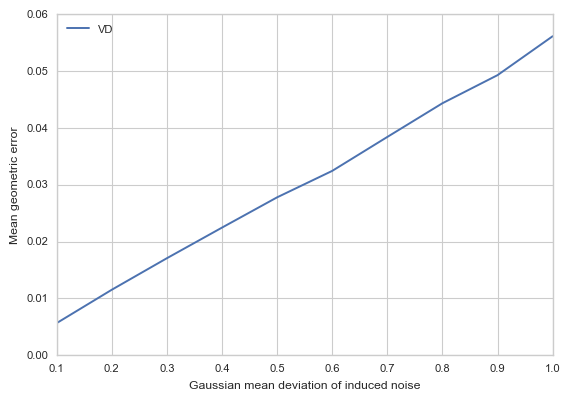

In [87]:
fig, ax = plt.subplots(1)
# ax.plot(noise_levels, d['Ti']['trs'], label='Ti trs')
# ax.plot(noise_levels, d['Ti']['rot'], label='Ti rot')
ax.plot(noise_levels, d['VD']['rot'], label='VD')
ax.legend(frameon=False, loc=2)
ax.set_ylabel('Mean geometric error')
ax.set_xlabel('Gaussian mean deviation of induced noise')
# fig.savefig('/Users/lars/latex/latex-phd-thesis/Figures/points-est-deviation.pdf')